In [ ]:
!pip install transformers datasets gradio matplotlib nltk wordcloud shap scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does n

In [ ]:
import json
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

import shap
import gradio as gr

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Load the dataset (make sure sarcasm_data.json is uploaded to your Colab workspace)
with open('sarcasm_data.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary to a list of records
records = []
for key, item in data.items():
    # Use the 'utterance' as the text and convert the 'sarcasm' boolean to an integer (1 for sarcastic, 0 for non-sarcastic)
    records.append({
        'text': item['utterance'],
        'label': int(item['sarcasm'])
    })

df = pd.DataFrame(records)
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (690, 2)
                                                text  label
0  It's just a privilege to watch your mind at work.      1
1  I don't think I'll be able to stop thinking ab...      1
2  Since it's not bee season, you can have my epi...      0
3  Lois Lane is falling, accelerating at an initi...      0
4  I'm just inferring this is a couch because the...      1


In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove hashtags (but keep the word)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove emojis and non-ascii characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
print(df[['text', 'clean_text']].head())

                                                text  \
0  It's just a privilege to watch your mind at work.   
1  I don't think I'll be able to stop thinking ab...   
2  Since it's not bee season, you can have my epi...   
3  Lois Lane is falling, accelerating at an initi...   
4  I'm just inferring this is a couch because the...   

                                          clean_text  
0  It's just a privilege to watch your mind at work.  
1  I don't think I'll be able to stop thinking ab...  
2  Since it's not bee season, you can have my epi...  
3  Lois Lane is falling, accelerating at an initi...  
4  I'm just inferring this is a couch because the...  


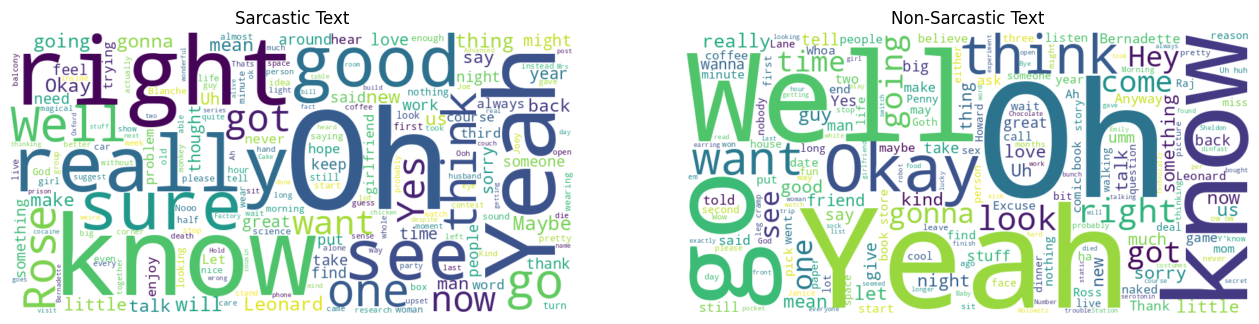

                                          clean_text  sentiment
0  It's just a privilege to watch your mind at work.     0.3612
1  I don't think I'll be able to stop thinking ab...    -0.2960
2  Since it's not bee season, you can have my epi...     0.0000
3  Lois Lane is falling, accelerating at an initi...     0.4215
4  I'm just inferring this is a couch because the...     0.0000


In [ ]:
# Separate the data
sarcastic_text = " ".join(df[df['label'] == 1]['clean_text'].tolist())
non_sarcastic_text = " ".join(df[df['label'] == 0]['clean_text'].tolist())

# Generate word clouds
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_text)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_text)

# Plot the word clouds
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(wordcloud_sarcastic, interpolation='bilinear')
ax[0].set_title("Sarcastic Text")
ax[0].axis('off')

ax[1].imshow(wordcloud_non_sarcastic, interpolation='bilinear')
ax[1].set_title("Non-Sarcastic Text")
ax[1].axis('off')

plt.show()

# Sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print(df[['clean_text', 'sentiment']].head())

In [ ]:
# Split into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Load XLNet tokenizer (using a non-BERT model)
model_name = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['clean_text'], truncation=True)

# Convert Pandas DataFrames to Hugging Face datasets
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Train shape: (552, 4)
Test shape: (138, 4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/138 [00:00<?, ? examples/s]

In [ ]:
# Load XLNet model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define compute_metrics function for evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Set training arguments
training_args = TrainingArguments(
    output_dir="./xlnet-sarcasm",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-18cb6faa57ae>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gaurav314 (gaurav314-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.719200,0.686680,0.528986,0.471545,0.537037,0.420290
2,0.701300,0.662949,0.572464,0.549618,0.580645,0.521739
3,0.543500,0.637915,0.608696,0.602941,0.611940,0.594203


TrainOutput(global_step=207, training_loss=0.671119183157953, metrics={'train_runtime': 1038.0333, 'train_samples_per_second': 1.595, 'train_steps_per_second': 0.199, 'total_flos': 34604051456832.0, 'train_loss': 0.671119183157953, 'epoch': 3.0})

Evaluation Results: {'eval_loss': 0.637914776802063, 'eval_accuracy': 0.6086956521739131, 'eval_f1': 0.6029411764705882, 'eval_precision': 0.6119402985074627, 'eval_recall': 0.5942028985507246, 'eval_runtime': 52.9068, 'eval_samples_per_second': 2.608, 'eval_steps_per_second': 0.34, 'epoch': 3.0}
              precision    recall  f1-score   support

           0       0.61      0.62      0.61        69
           1       0.61      0.59      0.60        69

    accuracy                           0.61       138
   macro avg       0.61      0.61      0.61       138
weighted avg       0.61      0.61      0.61       138



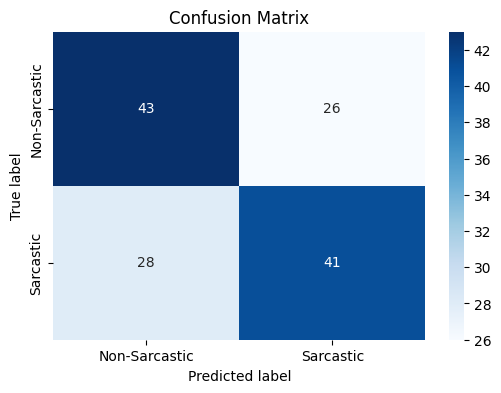

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Get predictions for confusion matrix
preds_output = trainer.predict(test_dataset)
predictions = np.argmax(preds_output.predictions, axis=-1)
true_labels = preds_output.label_ids

# Display classification report and confusion matrix
print(classification_report(true_labels, predictions))

import seaborn as sns
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Sarcastic", "Sarcastic"], yticklabels=["Non-Sarcastic", "Sarcastic"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
!pip install --upgrade gradio
import gradio as gr

def predict_sarcasm(text):
    # Preprocess the input text
    clean_input = clean_text(text)
    inputs = tokenizer(clean_input, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().numpy()[0]
    label = "Sarcastic" if np.argmax(probs) == 1 else "Non-Sarcastic"
    return label, {"Non-Sarcastic": float(probs[0]), "Sarcastic": float(probs[1])}

# Build the Gradio Interface
# Updated to use gr.Textbox instead of gr.inputs.Textbox
# Updated to use gr.Label instead of gr.outputs.Label
iface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=3, placeholder="Enter text here..."), # Updated
    outputs=[gr.Label(num_top_classes=2), gr.Label(label="Probabilities")], # Updated
    title="Sarcasm Sleuth",
    description="Enter a sentence to see if it is sarcastic or not."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d23e150e2c0736474.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
